In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf

from pksd.ksd import KSD, OSPKSD, SPKSD
from pksd.kernel import IMQ
import pksd.langevin as mcmc

In [2]:
tf.random.set_seed(2022)

# Set-ups: Bi-modal mixture of Gaussian
We consider the first example in the experiments section of the paper. The target density is
$$
    p(x) \propto \pi_p \exp\left( - 0.5 * \| x \|_2^2 \right) + (1 - \pi_p) \exp\left( -0.5 * \| x - e_1\|_2^2 \right),
$$
where $\pi_p = 0.5$, and $e_1 = (1, 0, \ldots, 0)^\intercal \in \mathbb{R}^d$.

In [3]:
dim = 1
pi_p = 0.5

In [4]:
mean1 = tf.zeros(dim)
mean2 = tf.eye(dim)[0, :] * 6.

def log_prob(x, ratio=pi_p):
    """Log prob density of the target up to an additive constant"""
    log_ratio1 = tf.math.log(ratio)
    log_ratio2 = tf.math.log(1-ratio)
    
    exp1 = tf.reduce_sum((x - mean1)**2, axis=-1) # n
    exp2 = tf.reduce_sum((x - mean2)**2, axis=-1) # n
    exps = tf.stack([-0.5 * exp1 + log_ratio1, -0.5 * exp2 + log_ratio2]) # 2 x n
    return tf.math.reduce_logsumexp(exps, axis=0) # n

2023-06-09 09:38:11.922162: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 09:38:15.723332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-06-09 09:38:15.724623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9658 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2023-06-09 09:38:15.725912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/de

Samples are drawn from the *left component*, i.e. the same density but with $\pi_p$ replaced by $\pi_q = 1$.

In [5]:
def sample_from_Q(n, ratio):
    """Sample from the candidate distribution"""
    mix1 = tf.random.normal((n, dim)) + mean1
    mix2 = tf.random.normal((n, dim)) + mean2
    unif = tf.random.uniform((n, 1))
    x = tf.where(unif <= ratio, mix1, mix2)
    return x

In [6]:
# draw sample
n = 1000
samples = sample_from_Q(n, ratio=1.)

# KSD test
The goal is to test $H_0: Q = P$ against $H_1: Q \neq P$.

To perform KSD test, we need to instantiate
1. a positive definite kernel: we use IMQ kernels with the median heuristic (see paper for details)
2. a KSD object, which takes in a p.d. kernel and the log prob of the target

In [7]:
kernel = IMQ(med_heuristic=True)
ksd = KSD(kernel=kernel, log_prob=log_prob)

In [8]:
# compute test statistic and p-value using 1000 bootstrap samples 
ksd_hat, ksd_pval = ksd.test(x=samples, num_boot=1000)

print("KSD test: \ntest statistic: {:.3g}, p-value: {:.3g}".format(ksd_hat, ksd_pval))

2023-06-09 09:38:16.760184: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


The large $p$-value suggests no evidence of rejection, even though the sample has completely missed the other mode. 

This is because the score functions of the target distribution $P$ and the candidate distribution $Q$ are very similar on regions where we have sample.

(Even though the population KSD is always non-negative, the test statistic can be negative because a U-statistic does not ensure positivity.)

# spKSD test and ospKSD test
To perform the spKSD test or ospKSD test, we need to provide a few more things (see paper for details):
1. A collection of candidate perturbation kernels $\mathcal{S} = \{\mathcal{K}_1, \ldots, \mathcal{K}_s \}$: in this case each $\mathcal{K}_s$ is a MH transition kernel leaving $p$ invariant.
    - For spKSD, the entire $\mathcal{S}$ will be used to compute the test statistic.
    - For ospKSD, one optimal kernel will be selected from $\mathcal{S}$ to compute the test statistic. 
2. Number of steps to apply the perturbation kernel.
3. A list of candidate jump scales for the transition kernel,
4. Starting points for the optimiser

For ospKSD, we also need
5. A training set for finding the optimal transition kernel from $\mathcal{S}$, and a test set for computing the p-value.

## 1. spKSD

In [ ]:
# MH transition kernel
mh_kernel = mcmc.RandomWalkMH

# number of steps to apply transition kernel
T = 10

# candidate jump scales
jump_ls = tf.linspace(0.5, 1.5, 21)

# starting points to initialise optimiser for finding
# modes and Hessians
init_points = tf.random.uniform((n, dim), minval=-10, maxval=10) # ntrain x dim

In [ ]:
# instantiate sPKSD class
spksd = SPKSD(kernel=kernel, pert_kernel=mh_kernel, log_prob=log_prob)

In [ ]:
# find modes and Hessians
spksd.find_modes(init_points, threshold=1., max_iteration=500)

2023-06-09 08:40:29.969791: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x48aa4430


In [ ]:
# compute test statistic and p-value using 1000 bootstrap samples 
spksd_hat, spksd_pval = spksd.test(
    x=samples, 
    T=T, 
    jump_ls=jump_ls, 
    num_boot=1000, 
  )

print("spKSD test: \ntest statistic: {:.3g}, p-value: {:.3g}".format(spksd_hat, spksd_pval))

spKSD test: 
test statistic: 1.23, p-value: 0.000999


## 2. ospKSD 

ospKSD follows a similar logic. 

The initial points for the optimiser are randomly generated. However, we could also use the **training set** (or both) for potentially faster convergence. This would **not** affect the validity of the test result as the $p$-value will be computed from a held-out set. 

In [ ]:
# train/test split
ntrain = n//2
sample_train, sample_test = samples[:ntrain, ], samples[ntrain:, ]

# starting points to initialise optimiser for finding
# modes and Hessians
init_points = tf.random.uniform((ntrain, dim), minval=-10, maxval=10)

###########################################################################
# alternatively, use both the training set and randomly generated points
###########################################################################
# init_points = tf.concat([
#     sample_train[:(ntrain//2)], 
#     tf.random.uniform((ntrain//2, dim), minval=-10, maxval=10) 
# ], axis=0)

In [ ]:
# instantiate PKSD class
ospksd = OSPKSD(kernel=kernel, pert_kernel=mh_kernel, log_prob=log_prob)

In [ ]:
# find modes and Hessians
ospksd.find_modes(init_points, threshold=1., max_iteration=500)

In [ ]:
# compute test statistic and p-value using 1000 bootstrap samples 
ospksd_hat, ospksd_pval = ospksd.test(
    xtrain=sample_train, 
    xtest=sample_test, 
    T=T, 
    jump_ls=jump_ls, 
    num_boot=1000, 
  )

print("ospKSD test: \ntest statistic: {:.3g}, p-value: {:.3g}".format(ospksd_hat, ospksd_pval))

ospKSD test: 
test statistic: 0.109, p-value: 0.000999


Unlike KSD, the small $p$-value of the ospKSD test suggests a clear rejection at a level $\alpha = 0.05$, demonstrating the capability of the chosen perturbation in detecting differences in mixing proportions.

A similar observation could be drawn if the sample was drawn from *both* components but with a different mixing proportion, i.e., setting $\pi_q \in (0, 1)$ with $\pi_q \neq \pi_p$.

# Samples before and after perturbation (thumbnail)
We visualise the samples before and after the optimal perturbation selected in ospKSD.

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
mpl.rcParams["mathtext.fontset"] = "cm"

In [ ]:
# samples before perturbation
# use more samples for clearer visualisation
samples_before_plot = sample_from_Q(1000000, ratio=1.)

# store samples before and after perturbation
samples_df = pd.DataFrame({
    "x": tf.concat([samples_before_plot[:, 0], ospksd.x[-1, :, 0]], axis=0),
    "type": ["Before"]*samples_before_plot.shape[0] + ["After"]*(n-ntrain)
})

# ground-truth p density
xx = tf.reshape(tf.linspace(-5., 15., 1000), (-1, 1))
den_p = tf.exp(log_prob(xx, ratio=pi_p)) / tf.math.sqrt(2 * tf.experimental.numpy.pi)
p_df = pd.DataFrame({"x": xx[:, 0].numpy(), "prob": den_p.numpy()})

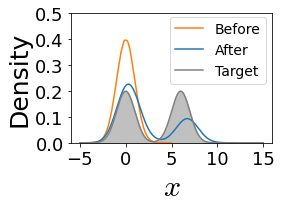

In [ ]:
fig = plt.figure(figsize=(4, 3))
sns.kdeplot(
    data=samples_df.loc[samples_df.type == "Before"], 
    x="x", 
    color="C1",
    label="Before",
)
sns.kdeplot(
    data=samples_df.loc[samples_df.type == "After"], 
    x="x", 
    color="C0",
    label="After",
)
sns.lineplot(
    data=p_df,
    x="x",
    y="prob",
    color="grey",
    label="Target",
)
plt.fill_between(p_df.x, p_df.prob, color="silver")

plt.xlabel("$x$", fontsize=30)
plt.ylabel("Density", fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(top=0.5)
plt.legend(
    fontsize=14, loc="upper center", bbox_to_anchor=(0.73, 1.03),
)
plt.tight_layout()
# fig.savefig("figs/thumbnail.pdf")